# Clasificación K-nearest neighbor

### Importamos paquetes y conjunto de datos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas.testing as tm
%matplotlib inline

df = pd.read_csv("https://github.com/ulewis/Ejemplos/raw/main/Datos/Classified_Data.txt",index_col=0)
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WTT           1000 non-null   float64
 1   PTI           1000 non-null   float64
 2   EQW           1000 non-null   float64
 3   SBI           1000 non-null   float64
 4   LQE           1000 non-null   float64
 5   QWG           1000 non-null   float64
 6   FDJ           1000 non-null   float64
 7   PJF           1000 non-null   float64
 8   HQE           1000 non-null   float64
 9   NXJ           1000 non-null   float64
 10  TARGET CLASS  1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 93.8 KB


In [3]:
df.describe()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.949682,1.114303,0.834127,0.682099,1.032336,0.943534,0.963422,1.071960,1.158251,1.362725,0.50000
std,0.289635,0.257085,0.291554,0.229645,0.243413,0.256121,0.255118,0.288982,0.293738,0.204225,0.50025
min,0.174412,0.441398,0.170924,0.045027,0.315307,0.262389,0.295228,0.299476,0.365157,0.639693,0.00000
25%,0.742358,0.942071,0.615451,0.515010,0.870855,0.761064,0.784407,0.866306,0.934340,1.222623,0.00000
50%,0.940475,1.118486,0.813264,0.676835,1.035824,0.941502,0.945333,1.065500,1.165556,1.375368,0.50000
75%,1.163295,1.307904,1.028340,0.834317,1.198270,1.123060,1.134852,1.283156,1.383173,1.504832,1.00000
max,1.721779,1.833757,1.722725,1.634884,1.650050,1.666902,1.713342,1.785420,1.885690,1.893950,1.00000


### Verificamos la extensión de las características

In [4]:
l=list(df.columns)
l[0:len(l)-2]

['WTT', 'PTI', 'EQW', 'SBI', 'LQE', 'QWG', 'FDJ', 'PJF', 'HQE']

**Ejecutamos un bucle 'for' para dibujar boxlots de todas las características para la CLASE OBJETIVO '0' y '1'**

In [5]:
for i in range(len(l)-1):
    sns.boxplot(x='TARGET CLASS',y=l[i], data=df)
    plt.figure()

### Escalamos las características usando el paquete sklearn.preprocessing

**Creamos una instancia de un estimador standardizing scaler**

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

**Ajustamos los datos de características solo a este estimador (dejando la columna CLASE OBJETIVO) y transformamos**

In [7]:
scaler.fit(df.drop('TARGET CLASS',axis=1))
scaled_features = scaler.transform(df.drop('TARGET CLASS',axis=1))

In [8]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


### División de Entrenamiento/Prueba, ajuste de modelo y predicción

In [9]:
from sklearn.model_selection import train_test_split
X = df_feat
y = df['TARGET CLASS']
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['TARGET CLASS'],
                                                    test_size=0.50, random_state=101)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
k=40
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)

,n_neighbors,40
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [11]:
pred = knn.predict(X_test)

**Evaluación de la calidad de clasificación**

In [12]:
from sklearn.metrics import classification_report,confusion_matrix
conf_mat=confusion_matrix(y_test,pred)
print(conf_mat)

[[237  13]
 [ 10 240]]


In [13]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       250
           1       0.95      0.96      0.95       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



In [14]:
print("Tasa de error de clasificación errónea:",round(np.mean(pred!=y_test),3))

Tasa de error de clasificación errónea: 0.046


**Elegimos 'k' por el método del elbow**

In [15]:
error_rate = []
# nos encuentra la relacion entre el error y K
# Tomará algún tiempo
# hacer esto con división de los datos de entrenamiento
# dividir en folds los datos de entrenamiento
# el test nunca entra en ajuste de hiperparámetros: k
for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

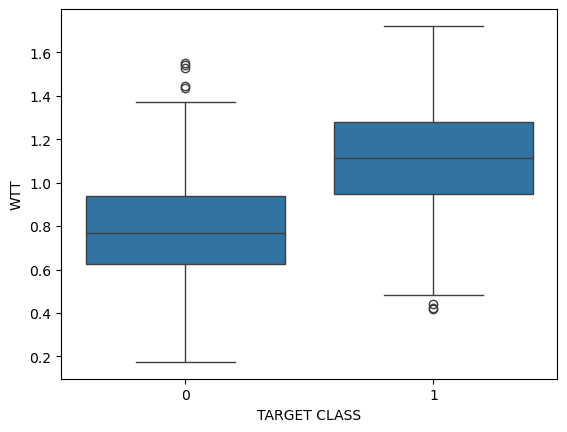

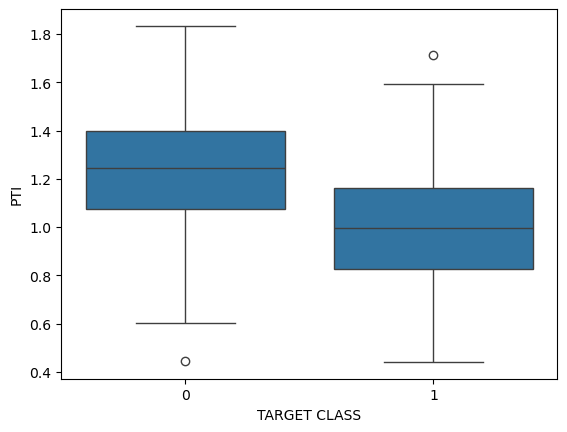

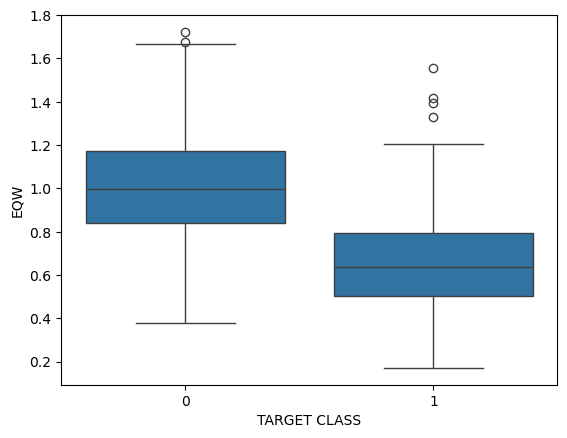

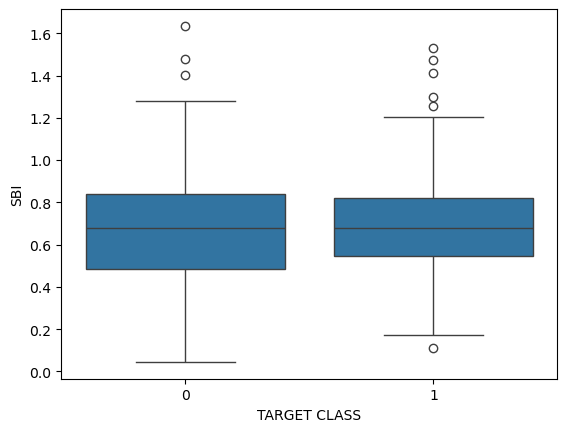

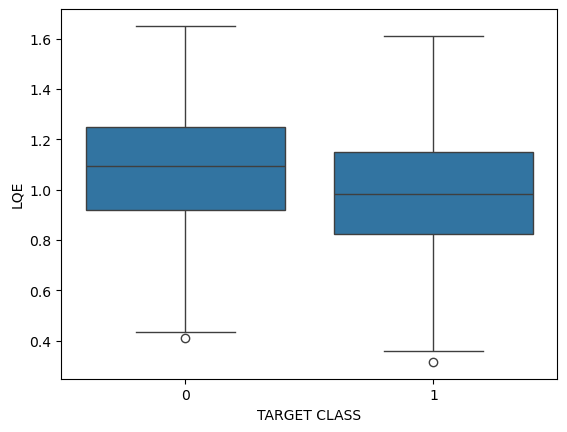

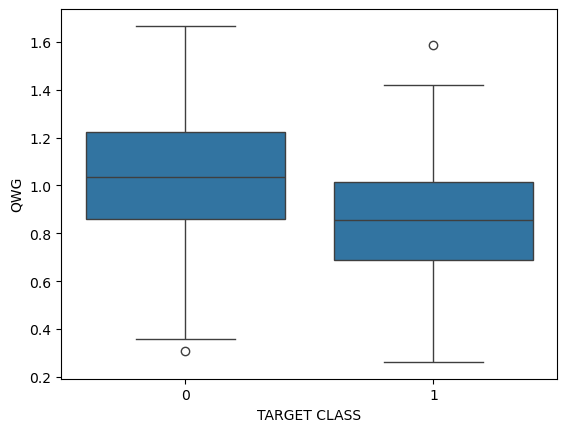

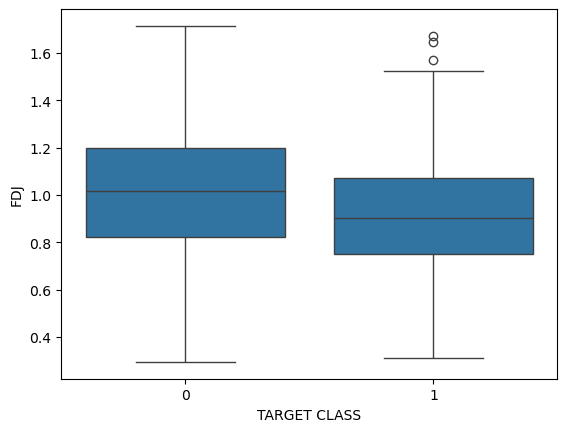

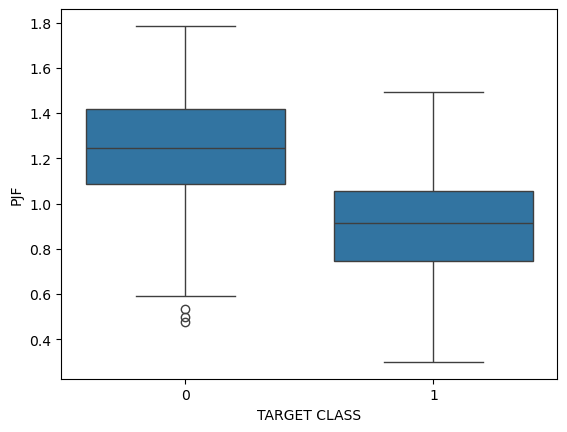

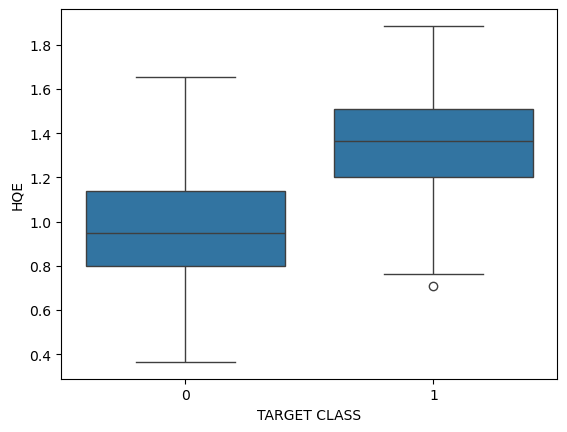

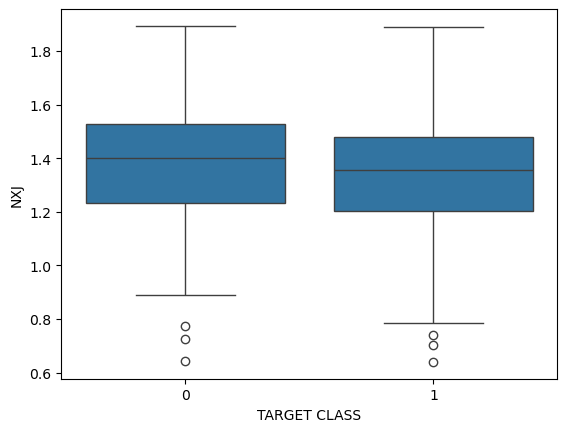

<Figure size 640x480 with 0 Axes>

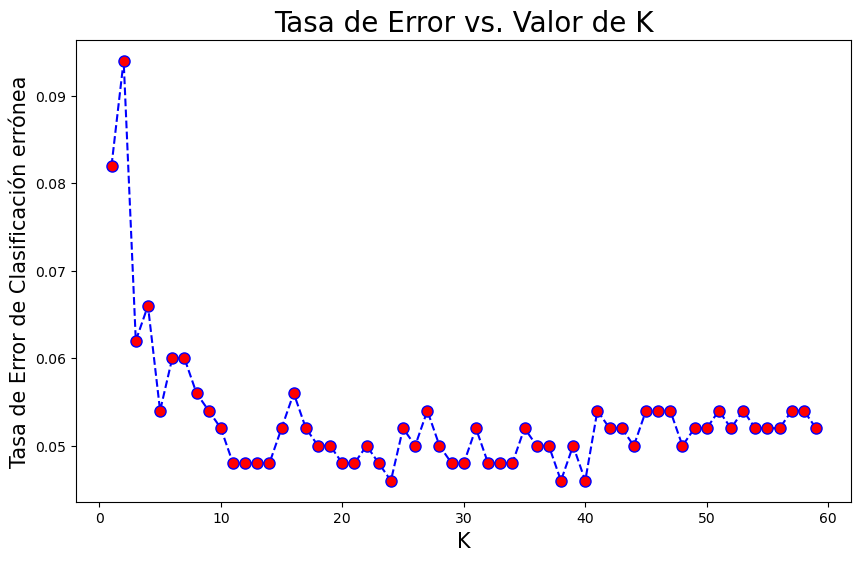

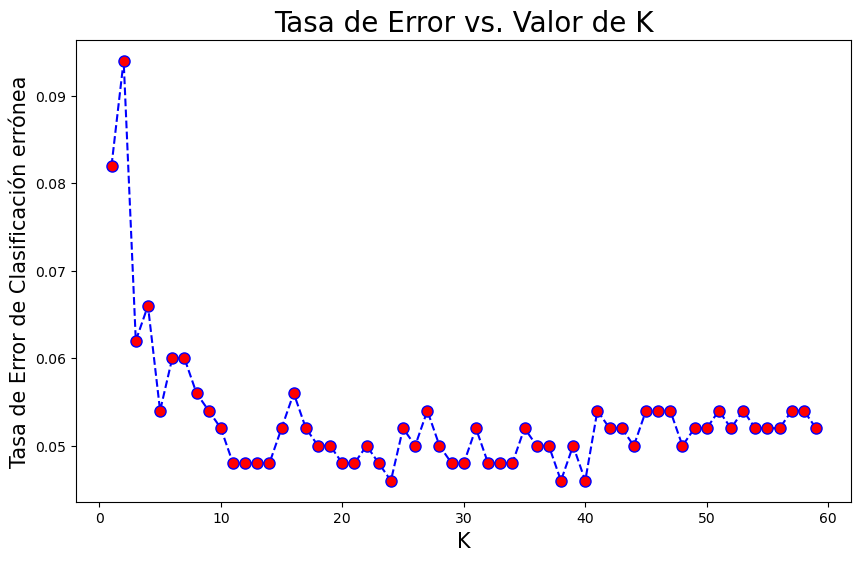

In [17]:
plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Tasa de Error vs. Valor de K', fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('Tasa de Error de Clasificación errónea',fontsize=15)
plt.show()